# **Análisis Exploratorio de Datos (EDA)**

### **Librerias**

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson


In [ ]:
# Cargar el dataset
df = pd.read_csv("dataset_final.csv") 

In [52]:
# Ver dimensiones
print("Dimensiones del dataset:")
print(f"Filas: {df.shape[0]:,}")
print(f"Columnas: {df.shape[1]:,}")

Dimensiones del dataset:
Filas: 144,233
Columnas: 73


In [53]:
# Ver primeras filas
print("\nPrimeras filas del dataset:")
df.head()


Primeras filas del dataset:


,id_01,id_02,id_05,id_06,id_09,id_10,id_19,id_20,isfraud,transactiondt,...,v296,v301,v311,v313,v314,v326,v335,v338,id_38,card6
0,0.0,70787.0,0.0,0.0,0.000000,-2.800000,542.0,144.0,0.0,86506.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,T,credit
1,-5.0,98945.0,0.0,-5.0,0.000000,-0.400000,621.0,500.0,0.0,86535.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,T,debit
2,-5.0,191631.0,0.0,0.0,0.000000,0.000000,410.0,142.0,0.0,86549.0,...,1.0,1.0,31.841299,90.327904,90.327904,0.000000,0.000000,30.000000,T,credit
3,-5.0,221832.0,0.0,-6.0,0.091023,-0.301124,176.0,507.0,0.0,86555.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.851416,59.213495,151.546395,T,debit
4,0.0,7460.0,1.0,0.0,0.000000,0.000000,529.0,575.0,0.0,86620.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,T,debit


In [54]:
# Ver resumen de tipos de datos
print("Tipos de datos en el dataset")
print(df.dtypes.value_counts())

# Ver cantidad de valores nulos por columna (top 20)
print("\nValores nulos por columna")
nulls = df.isnull().sum().sort_values(ascending=False)
print(nulls[nulls > 0].head(20))


Tipos de datos en el dataset
float64    71
object      2
Name: count, dtype: int64

Valores nulos por columna
Series([], dtype: int64)


In [55]:
# Reafirmar columnas categóricas tipo object
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Total de filas
total = len(df)

# Recorrer cada columna categórica y mostrar valores únicos + porcentaje
for col in categorical_cols:
    print(f"\n=== {col} ===")
    counts = df[col].value_counts(dropna=False)
    percentages = counts / total * 100
    summary = pd.DataFrame({
        'Valor': counts.index,
        'Frecuencia': counts.values,
        'Porcentaje': percentages.round(2)
    })
    print(summary)



=== id_38 ===
      Valor  Frecuencia  Porcentaje
id_38                              
F         F       77170        53.5
T         T       67063        46.5

=== card6 ===
                   Valor  Frecuencia  Porcentaje
card6                                           
credit            credit       75268       52.19
debit              debit       68950       47.80
charge card  charge card          15        0.01


In [56]:
# Eliminar registros donde card6 es "charge card"
df = df[df['card6'] != 'charge card'].reset_index(drop=True)

print(f"Nuevo tamaño del dataset: {df.shape}")
print(df['card6'].value_counts(normalize=True) * 100)


Nuevo tamaño del dataset: (144218, 73)
card6
credit    52.190434
debit     47.809566
Name: proportion, dtype: float64


In [57]:
info = pd.DataFrame({
    'Columna': df.columns,
    'Tipo de dato': df.dtypes,
    'Valores únicos': df.nunique()
})

# Ordenar por tipo de dato (opcional)
info = info.sort_values(by='Tipo de dato').reset_index(drop=True)

pd.set_option('display.max_rows', None)
print(info)


           Columna Tipo de dato  Valores únicos
0            id_01      float64              77
1             v261      float64              97
2             v250      float64              27
3             v238      float64              34
4             v229      float64             191
5             v227      float64              61
6             v226      float64             102
7             v267      float64            6231
8             v225      float64              83
9             v223      float64              42
10            v220      float64              43
11            v208      float64            3171
12            v185      float64              46
13            v184      float64              31
14            v177      float64             891
15            v224      float64             160
16            v175      float64              31
17            v271      float64            3165
18            v277      float64            4052
19            v338      float64         

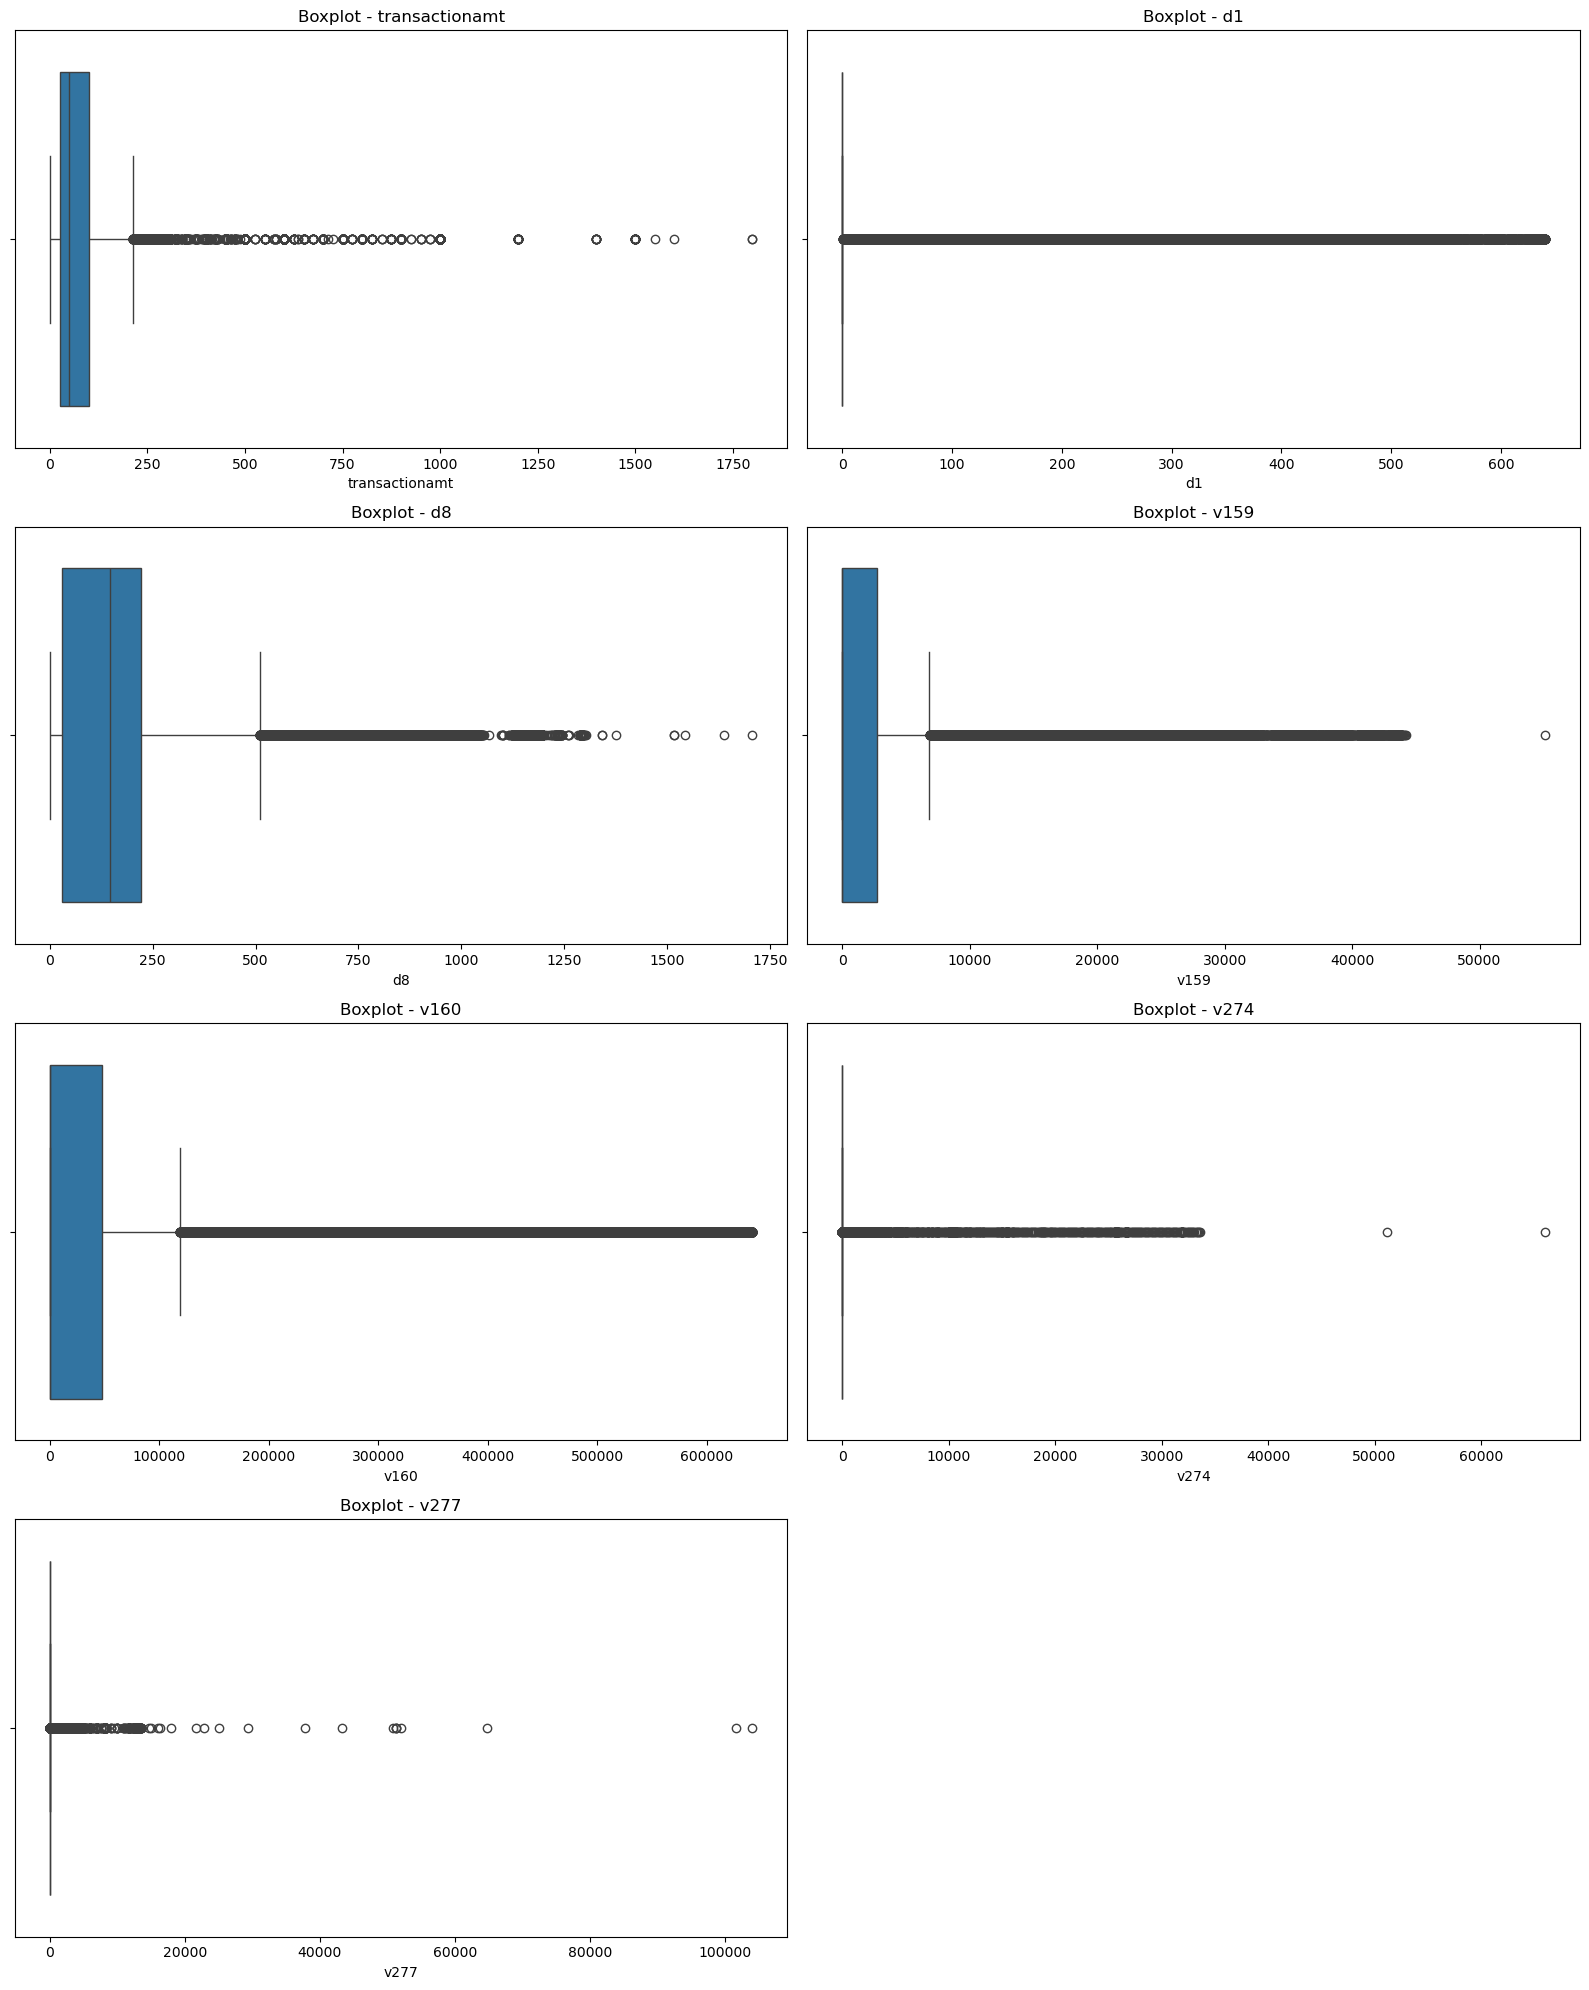

In [58]:
# Lista final de variables
vars_outliers = ['transactionamt', 'd1', 'd8', 'v159', 'v160', 'v274', 'v277']

plt.figure(figsize=(16, 20))

for i, col in enumerate(vars_outliers):
    plt.subplot(4, 2, i+1)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot - {col}')
    plt.tight_layout()

plt.show()


In [59]:
# Usamos la columna original o la winsorizada
data = df['transactionamt']

result = anderson(data)

print("=== Anderson-Darling Test ===")
print(f"Estadístico A: {result.statistic:.4f}")
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    print(f"Nivel de significancia: {sl:.1f}% | Valor crítico: {cv:.4f}")
    
if result.statistic > result.critical_values[2]:  
    print("\nConclusión: Rechazamos H0 → No es normal")
else:
    print("\nConclusión: No se rechaza H0 → Podría ser normal")


=== Anderson-Darling Test ===
Estadístico A: 11934.4809
Nivel de significancia: 15.0% | Valor crítico: 0.5760
Nivel de significancia: 10.0% | Valor crítico: 0.6560
Nivel de significancia: 5.0% | Valor crítico: 0.7870
Nivel de significancia: 2.5% | Valor crítico: 0.9180
Nivel de significancia: 1.0% | Valor crítico: 1.0920

Conclusión: Rechazamos H0 → No es normal


In [60]:
import numpy as np

# Transformación logarítmica segura (log(1 + x)) para evitar log(0)
df['transactionamt_log'] = np.log1p(df['transactionamt'])


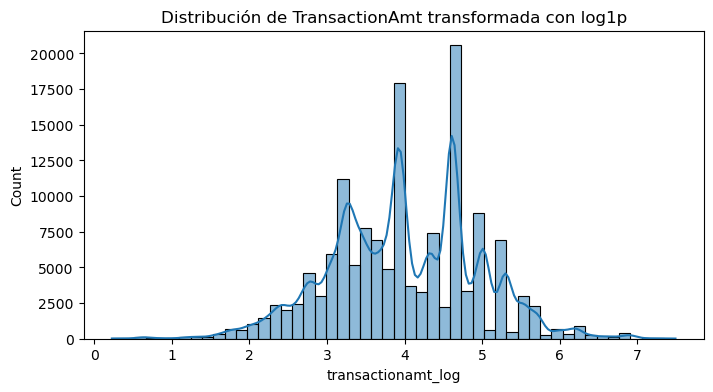

In [61]:

plt.figure(figsize=(8, 4))
sns.histplot(df['transactionamt_log'], bins=50, kde=True)
plt.title("Distribución de TransactionAmt transformada con log1p")
plt.show()


In [62]:
# Prueba sobre la variable transformada
result_log = anderson(df['transactionamt_log'])

print("=== Anderson-Darling sobre log1p(TransactionAmt) ===")
print(f"Estadístico A: {result_log.statistic:.4f}")
for i in range(len(result_log.critical_values)):
    sl, cv = result_log.significance_level[i], result_log.critical_values[i]
    print(f"Nivel de significancia: {sl:.1f}% | Valor crítico: {cv:.4f}")
    
if result_log.statistic > result_log.critical_values[2]:  # 5%
    print("\nConclusión: Rechazamos H0 → no es normal")
else:
    print("\nConclusión: No se rechaza H0 → Podría ser normal")


=== Anderson-Darling sobre log1p(TransactionAmt) ===
Estadístico A: 424.5350
Nivel de significancia: 15.0% | Valor crítico: 0.5760
Nivel de significancia: 10.0% | Valor crítico: 0.6560
Nivel de significancia: 5.0% | Valor crítico: 0.7870
Nivel de significancia: 2.5% | Valor crítico: 0.9180
Nivel de significancia: 1.0% | Valor crítico: 1.0920

Conclusión: Rechazamos H0 → no es normal


In [63]:
# Eliminar columna original si ya no se usará
df = df.drop(columns=['transactionamt'])

# Renombrar la transformada para mantener consistencia
df.rename(columns={'transactionamt_log': 'transactionamt'}, inplace=True)

# Guardar
df.to_csv("fraude_final.csv", index=False)

print("Dataset guardado como 'fraude_final.csv' con la versión logarítmica.")


Dataset guardado como 'fraude_final.csv' con la versión logarítmica.
